# How to map a horizon in 3-D seismic data

This tutorial describes how to map stratigraphic horizons in a 3-D seismic volume using a variety of models. We start of really simple with a linear model prediction the depth (twt) of a horizon from a 1-D seismic trace. Then we explore the use of 1-D convolutional neural networks (CNN) for this task. Next, we go to two dimensions giving our model an idea of the surrounding traces.

## Setup ##
1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-4/tutorial-4.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


In [ ]:
!pip install googledrivedownloader
!pip install segpy

     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 112kB 40.7MB/s 


In [ ]:

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable




from google_drive_downloader import GoogleDriveDownloader as gdd

import segpy
from segpy.reader import create_reader




and download the 3-D seismic volume and the horizon:

In [ ]:
gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='15o_M_BWTS_Y9TXen4IYVmdJFz0xbUk3i',
                                    dest_path='./horizon.txt',
                                    unzip=False)

and load the data:

In [ ]:
filename = "./Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

scale the data:

In [ ]:
data = (data-np.min(data))/(np.max(data)-np.min(data))

and sort the data by inlines, crosslines and times:

In [ ]:
data = np.swapaxes(data, 1, 2)

(inlines, xlines, times) = data.shape

Next we load the interpretation:

In [ ]:
# Load interpretation
t_0            = 2
time_range     = 1848
scaling_factor = data.shape[2]/time_range

# Load horizon saved as Kingdom interpretation (ascii)
f=open('./horizon.txt',"r")
lines=f.readlines()

t = []
for line in lines:
    t.append((float(line.split()[4])-t_0)*data.shape[2]/time_range)
f.close()

t = np.array(t).reshape((651, 951))

plot it:

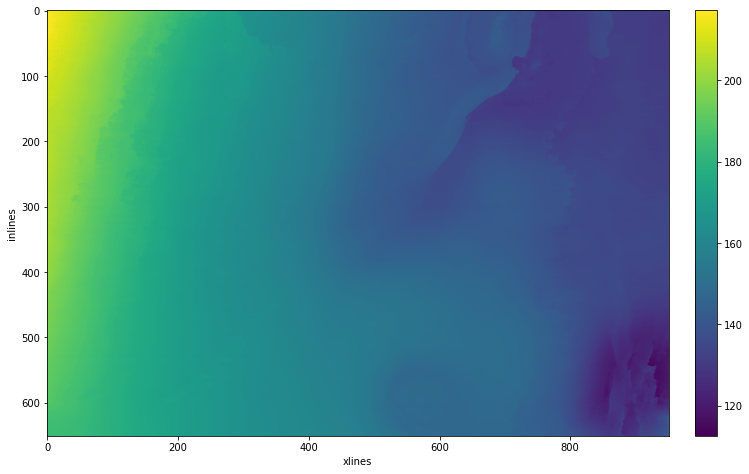

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(t)
plt.colorbar(fraction=0.0318, pad=0.04)
plt.xlabel('xlines')
plt.ylabel('inlines')
plt.show()

Now we calculate a scaling factor between the seismic data and the horizon in two-way traveltime and plot them together:

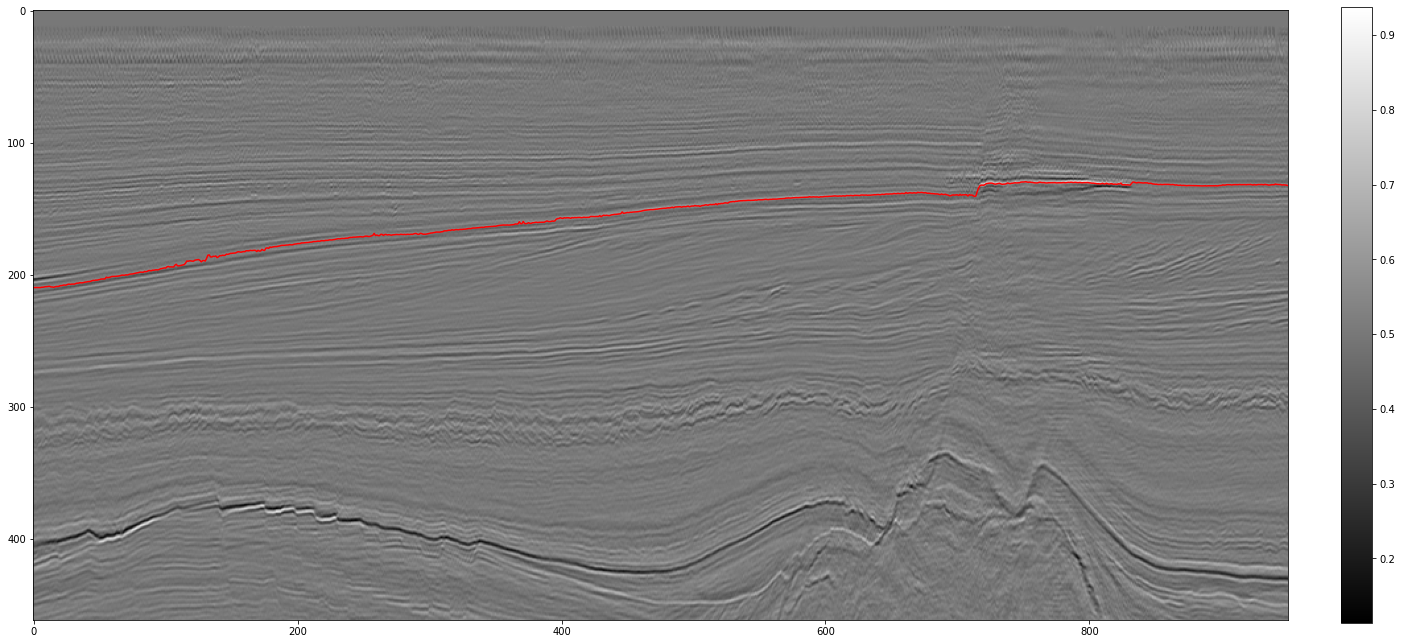

In [ ]:

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[100,:,:]), 'gray')
plt.plot(t[100,:], 'red')
plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

# 2-D CNN #

Okay, the prediction is a bit slow, maybe we can speed things up by simultaneously predicting the horizon for all traces in the batch:

In [ ]:
wsize = 10

def patchify(lines):
  X = np.zeros(((xlines-wsize)*len(lines), wsize, times, 1))
  y = np.zeros(((xlines-wsize)*len(lines), wsize, 1))
  m = 0
  for line in lines:
    for n in range(wsize//2, xlines-wsize//2):
      y[m,:,0] = t[line,n-wsize//2:n+wsize//2]
      X[m,:,:,0] = data[line, n-wsize//2:n+wsize//2, :]
      m += 1
  return X, y

lines_train = range(0,600,25)
lines_val   = [113,213,313,413,513,613]

X_train, y_train = patchify(lines_train)
X_val,   y_val   = patchify(lines_val)


In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout


model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=(wsize, times, 1)),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(wsize)])

model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics = ['mse'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 462, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 231, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 231, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 231, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 115, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 115, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7360)              0

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=100)

Epoch 1/100
706/706 [==============================] - 37s 6ms/step - loss: 28.5682 - mse: 2119.9472 - val_loss: 22.2074 - val_mse: 814.0323
Epoch 2/100
706/706 [==============================] - 4s 5ms/step - loss: 14.6810 - mse: 373.4517 - val_loss: 22.6677 - val_mse: 671.6354
Epoch 3/100
706/706 [==============================] - 3s 5ms/step - loss: 8.7135 - mse: 157.7968 - val_loss: 19.3678 - val_mse: 498.8488
Epoch 4/100
706/706 [==============================] - 4s 5ms/step - loss: 7.3487 - mse: 105.3419 - val_loss: 22.8176 - val_mse: 642.5675
Epoch 5/100
706/706 [==============================] - 4s 5ms/step - loss: 6.2249 - mse: 79.8320 - val_loss: 17.5936 - val_mse: 429.2582
Epoch 6/100
706/706 [==============================] - 4s 5ms/step - loss: 5.4921 - mse: 62.6175 - val_loss: 21.5383 - val_mse: 585.3419
Epoch 7/100
706/706 [==============================] - 4s 5ms/step - loss: 5.0666 - mse: 56.2418 - val_loss: 23.6893 - val_mse: 694.6428
Epoch 8/100
706/706 [============

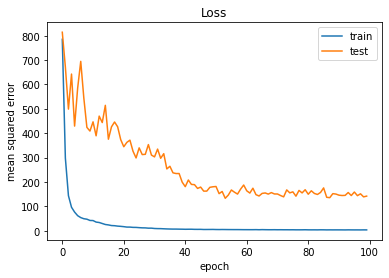

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
n_exp = len(range(wsize//2, 960-wsize//2, wsize))
X = np.zeros((n_exp, wsize, times, 1))

t_pred = np.zeros((inlines, xlines))


for inline in range(inlines):
  print(inline)
  m = 0
  for n in range(wsize//2, 960-wsize//2, wsize):
    X[m,:,:,0] = data[inline, n-wsize//2:n+wsize//2, :]
    m +=1

  prediction = model.predict(X)

  t_pred[inline,:950] = prediction.reshape(950)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

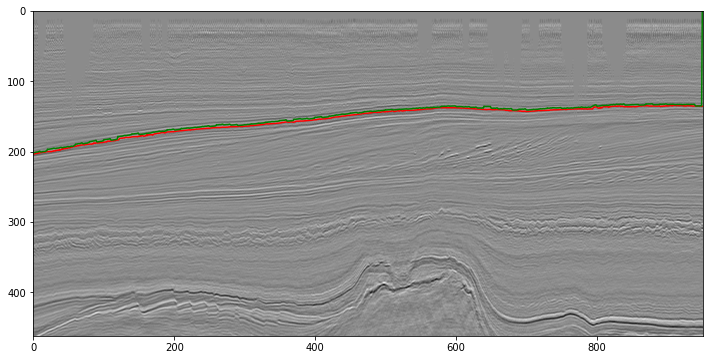

In [ ]:
example = 300


plt.figure(figsize=(12,12))
plt.imshow(np.transpose(data[300,:,:]), 'gray')
plt.plot(t[example,:], c='red')
plt.plot(t_pred[example,:], c='green')
plt.show()

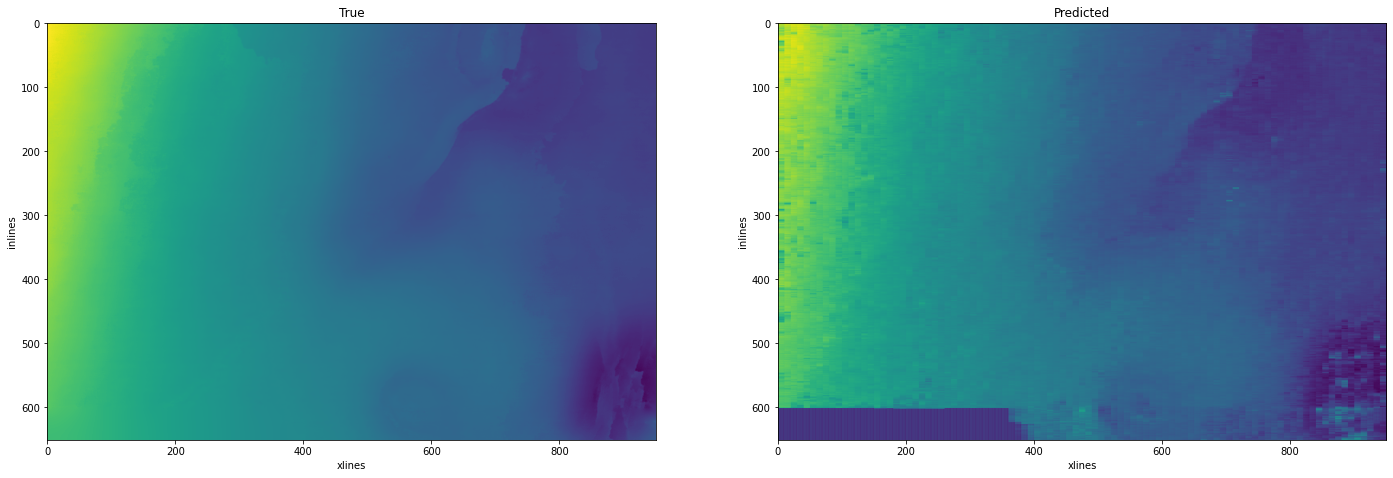

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24,24))

axs[0].imshow(t)
axs[0].set_title('True')
axs[0].set_xlabel('xlines')
axs[0].set_ylabel('inlines')

im = axs[1].imshow(t_pred, vmin=np.min(t), vmax=np.max(t))
axs[1].set_title('Predicted')
axs[1].set_xlabel('xlines')
axs[1].set_ylabel('inlines')

plt.show()